In [1]:
import os
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

#from jsonschema.benchmarks.contains import beginning

Nr 
Panel 
1. 
Copper Indium Gallium Selenide (CIGS), a flexible 
module; 
nominal efficiency Specifications 
12.7% specs 
2. 
Cadmium Telluride (CdTe), a lower cost module; 
12.0% specs 
3. 
Polycrystalline Silicon (Poly-Si), the most commonly 
used technology; 
15.5% specs 
4. 
Interdigitated Back Contact monocrystalline silicon, 
charge extraction located at the back of the cell;  
21.5% specs 
5. 
Heterojunction Intrinsic Layer Monocrystalline Silicon 
(HIT Si), highest lab-tested efficiency; 
19.4% specs 
6. 
Copper Indium Gallium Selenide (CIGS) with reflective 
backing; 
14.7% specs

In [2]:
def get_selected_months(years=None, months=None):
    """
    Generate a list of selected months based on user input for years and months.
    
    Parameters:
        years (list of int): List of years to include (e.g., [2017, 2018]).
        months (list of int): List of months to include (e.g., [1, 2, 3]).
        
    Returns:
        list of str: List of selected year_month combinations (e.g., ['2017_01', '2017_02']).
    """
    if years is None:
        years = [2017]  # Default year
    if months is None:
        months = range(1, 13)  # Default to all months

    selected_months = [f"{year}_{str(month).zfill(2)}" for year in years for month in months]
    return selected_months

In [5]:
def load_and_sync_data(base_path, selected_months, selected_csvs, debug=False):
    base_path = Path(base_path)
    if not base_path.is_dir():
        raise FileNotFoundError(f"The base path does not exist: {base_path}")

    # Dictionary to store DataFrames from each source
    source_dataframes = {}

    for csv_type in selected_csvs:
        combined_source_data = []

        for month in selected_months:
            year, month_number = month.split('_')
            year_folder = f"{year}_V3"
            month_folder = f"{year}_{month_number}"
            month_path = base_path / year_folder / month_folder

            if not month_path.is_dir():
                if debug:
                    print(f"Skipping non-existent directory: {month_path}")
                continue

            # Determine the correct file name for the source
            file_name_with_space = f"{csv_type}- {month_folder}.csv"
            file_name_without_space = f"{csv_type}-{month_folder}.csv"

            file_path = None
            if csv_type == "LightSpectra":
                # Handle LightSpectra's unique naming format
                file_path_with_space = month_path / file_name_with_space
                file_path_without_space = month_path / file_name_without_space
                if file_path_with_space.exists():
                    file_path = file_path_with_space
                elif file_path_without_space.exists():
                    file_path = file_path_without_space
            else:
                file_path = month_path / file_name_without_space

            if file_path and file_path.exists():
                try:
                    data_frame = pd.read_csv(file_path, low_memory=False)

                    # -------------------
                    # Standardize date/time columns
                    # -------------------
                    data_frame["Year"] = data_frame.get("Date[year]", year)
                    data_frame["Month"] = data_frame.get("Date[month]", month_number)
                    data_frame["Day"] = data_frame.get("Date[day]")
                    data_frame["Weekday"] = data_frame.get("Date[weekday]")

                    if "Time[hh:mm:ss]" in data_frame.columns:
                        data_frame["Time"] = data_frame["Time[hh:mm:ss]"]
                        data_frame.drop(columns=["Time[hh:mm:ss]"], errors="ignore", inplace=True)

                    data_frame.drop(
                        columns=[col for col in data_frame.columns if col.startswith("Date[")],
                        errors="ignore",
                        inplace=True
                    )

                    data_frame["Source"] = csv_type  # (optional metadata)
                    combined_source_data.append(data_frame)

                except Exception as e:
                    if debug:
                        print(f"Error loading file {file_path}: {e}")
            else:
                if debug:
                    print(f"File not found: {file_path}")

        # Concatenate all data for the current source
        if combined_source_data:
            source_dataframes[csv_type] = pd.concat(combined_source_data, ignore_index=True)

    # -------------------
    # Merge (inner join) across all sources on "AbsTime[s]"
    # -------------------
    synced_data = None
    for source, df in source_dataframes.items():
        if synced_data is None:
            synced_data = df
        else:
            synced_data = pd.merge(
                synced_data,
                df,
                on='AbsTime[s]',
                how='inner',
                suffixes=('', f'_{source}')
            )

    # -------------------
    # Consolidate duplicate columns
    # -------------------
    if synced_data is not None:
        for col in ["Year", "Month", "Day", "Time", "Weekday"]:
            # Gather all columns that start with "Year", "Month", etc.
            cols_to_merge = [c for c in synced_data.columns if c.startswith(col)]
            if len(cols_to_merge) > 1:
                # Fill "master" col with first non-NaN going left->right
                synced_data[col] = synced_data[cols_to_merge].bfill(axis=1).iloc[:, 0]
                # Drop duplicates except for the original "col"
                cols_to_drop = [c for c in cols_to_merge if c != col]
                synced_data.drop(columns=cols_to_drop, inplace=True, errors="ignore")

        # Remove the "Source" columns if no longer needed
        synced_data.drop(
            columns=[col for col in synced_data.columns if "Source" in col],
            errors="ignore",
            inplace=True
        )

        # Remove exact duplicated columns (rare leftover edge case)
        synced_data = synced_data.loc[:, ~synced_data.columns.duplicated()]

        return synced_data

    # If no data was found at all
    return pd.DataFrame()


if __name__ == "__main__":
    # Base path to the dataset
    base_path = "../../OneDrive - HvA/Jaar_4/PV systems modeling and analysis/Data/data_folder"
    base_path_bono = "../../school/4e jaar/PV systems modeling and analysis/Data/data_folder"

    # Specify months and sources to include
    selected_months = get_selected_months(years=[2021], months=[5,6])
    selected_csvs = ["SolarFieldData"]

    # Load and synchronize data
    synced_df = load_and_sync_data(base_path, selected_months, selected_csvs, debug=True)

    # Display the synchronized DataFrame
    print("\nSynchronized DataFrame:")
    print(synced_df.head())

    # # Save the synchronized data for later use (optional)
    # synced_df.to_csv("synced_data_january_2017_2018.csv", index=False)
    # print("Synchronized data saved to synced_data_january_2017_2018.csv")



Synchronized DataFrame:
   AbsTime[s]  Act Air Density (WeatherStation)  \
0  3828816000                               NaN   
1  3828816300                               NaN   
2  3828816600                               NaN   
3  3828816900                               NaN   
4  3828817200                               NaN   

   Act Wind Direction (WeatherStation)  \
0                                  NaN   
1                                  NaN   
2                                  NaN   
3                                  NaN   
4                                  NaN   

   Act Wind Measurement Quality (WeatherStation)  \
0                                            NaN   
1                                            NaN   
2                                            NaN   
3                                            NaN   
4                                            NaN   

   Act Wind Speed [km/h] (WeatherStation)  \
0                                     NaN   
1           

In [6]:
synced_df

,AbsTime[s],Act Air Density (WeatherStation),Act Wind Direction (WeatherStation),Act Wind Measurement Quality (WeatherStation),Act Wind Speed [km/h] (WeatherStation),Avg Absolute Air Pressure (WeatherStation),Avg Air Temperature (WeatherStation),Avg Dewpoint Temperature (WeatherStation),Avg Relative Humidity (WeatherStation),Avg Wind Speed [km/h] (WeatherStation),...,Clear light (LAD Sensor 12),Infrared light (LAD Sensor 12),Temperature [°C] (LAD Sensor 12),Gain (LAD Sensor 12),Integration time (LAD Sensor 12),Year,Month,Day,Weekday,Time
0,3828816000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2021,May,1,Saturday,00:00:00
1,3828816300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,6.8,0.0,192.0,2021,May,1,Saturday,00:05:00
2,3828816600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,6.5,0.0,192.0,2021,May,1,Saturday,00:10:00
3,3828816900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,6.5,0.0,192.0,2021,May,1,Saturday,00:15:00
4,3828817200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,6.5,0.0,192.0,2021,May,1,Saturday,00:20:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17563,3834084900,1.221169,0.0000,100.0,0.000000,1015.896,15.08232,12.95173,87.10642,1.201355,...,0.0,0.0,15.2,0.0,192.0,2021,June,30,Wednesday,23:35:00
17564,3834085200,1.221149,0.0000,100.0,0.000000,1015.932,15.06875,12.92241,87.01555,1.291014,...,0.0,0.0,15.2,0.0,192.0,2021,June,30,Wednesday,23:40:00
17565,3834085500,1.221200,0.0000,100.0,0.000000,1015.962,15.04553,12.88310,86.92194,1.174879,...,0.0,0.0,15.2,0.0,192.0,2021,June,30,Wednesday,23:45:00
17566,3834085800,1.220924,0.0000,100.0,0.000000,1015.987,15.09856,12.91005,86.77888,0.000000,...,0.0,0.0,15.2,0.0,192.0,2021,June,30,Wednesday,23:50:00


In [7]:
# 1) Maandnaam omzetten naar maandnummer
month_map = {
    'January': '01',
    'February': '02',
    'March': '03',
    'April': '04',
    'May': '05',
    'June': '06',
    'July': '07',
    'August': '08',
    'September': '09',
    'October': '10',
    'November': '11',
    'December': '12'
}
synced_df['Month_num'] = synced_df['Month'].map(month_map)

# 2) De kolommen Year, Month_num, Day en Time samenvoegen tot een datumstring
synced_df['datetime_str'] = (
    synced_df['Year'].astype(str) + '-' +
    synced_df['Month_num'].astype(str) + '-' +
    synced_df['Day'].astype(str) + ' ' +
    synced_df['Time'].astype(str)
)

# 3) Deze string parsen naar een datetime-kolom
synced_df['datetime'] = pd.to_datetime(synced_df['datetime_str'], format='%Y-%m-%d %H:%M:%S')

# 4) Zet deze nieuwe kolom als index van je DataFrame
synced_df.set_index('datetime', inplace=True)

# 5) (Optioneel) Opruimen: als je de losse kolommen niet meer nodig hebt:
synced_df.drop(columns=['Month_num', 'datetime_str'], inplace=True)

synced_df

,AbsTime[s],Act Air Density (WeatherStation),Act Wind Direction (WeatherStation),Act Wind Measurement Quality (WeatherStation),Act Wind Speed [km/h] (WeatherStation),Avg Absolute Air Pressure (WeatherStation),Avg Air Temperature (WeatherStation),Avg Dewpoint Temperature (WeatherStation),Avg Relative Humidity (WeatherStation),Avg Wind Speed [km/h] (WeatherStation),...,Clear light (LAD Sensor 12),Infrared light (LAD Sensor 12),Temperature [°C] (LAD Sensor 12),Gain (LAD Sensor 12),Integration time (LAD Sensor 12),Year,Month,Day,Weekday,Time
datetime,,,,,,,,,,,,,,,,,,,,,
2021-05-01 00:00:00,3828816000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2021,May,1,Saturday,00:00:00
2021-05-01 00:05:00,3828816300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,6.8,0.0,192.0,2021,May,1,Saturday,00:05:00
2021-05-01 00:10:00,3828816600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,6.5,0.0,192.0,2021,May,1,Saturday,00:10:00
2021-05-01 00:15:00,3828816900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,6.5,0.0,192.0,2021,May,1,Saturday,00:15:00
2021-05-01 00:20:00,3828817200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,6.5,0.0,192.0,2021,May,1,Saturday,00:20:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-30 23:35:00,3834084900,1.221169,0.0000,100.0,0.000000,1015.896,15.08232,12.95173,87.10642,1.201355,...,0.0,0.0,15.2,0.0,192.0,2021,June,30,Wednesday,23:35:00
2021-06-30 23:40:00,3834085200,1.221149,0.0000,100.0,0.000000,1015.932,15.06875,12.92241,87.01555,1.291014,...,0.0,0.0,15.2,0.0,192.0,2021,June,30,Wednesday,23:40:00
2021-06-30 23:45:00,3834085500,1.221200,0.0000,100.0,0.000000,1015.962,15.04553,12.88310,86.92194,1.174879,...,0.0,0.0,15.2,0.0,192.0,2021,June,30,Wednesday,23:45:00


In [8]:
# AbsTime[s],
# Act Air Density (WeatherStation),
# Act Wind Direction (WeatherStation),
# Act Wind Measurement Quality (WeatherStation),
# Act Wind Speed [km/h] (WeatherStation),
# Avg Absolute Air Pressure (WeatherStation),
# Avg Air Temperature (WeatherStation),
# Avg Dewpoint Temperature (WeatherStation),
# Avg Relative Humidity (WeatherStation),
# Avg Wind Speed [km/h] (WeatherStation),
# Precipitation Intensity [mm/h] (WeatherStation),
# Precipitation Type (WeatherStation),
# Module #_1 (Solarpanel parameters),
# Vmpp[V]_1 (Solarpanel parameters),
# Impp[A]_1 (Solarpanel parameters),
# Pmpp[W]_1 (Solarpanel parameters),
# Voc[V]_1 (Solarpanel parameters),
# Isc[A]_1 (Solarpanel parameters),
# FF[%]_1 (Solarpanel parameters),
# G[W/mï½²]_1 (Solarpanel parameters),
# Tmodul[ï½°C]_1 (Solarpanel parameters),
# G_pyranometer[W/mï½²]_1 (Solarpanel parameters),
# V Range_1 (Solarpanel parameters),
# I Range_1 (Solarpanel parameters),
# Scan Rate[S/sec.]_1 (Solarpanel parameters),
# Observed Efficiency_1 (Solarpanel parameters),
# Year,Month,Day,Weekday,Time

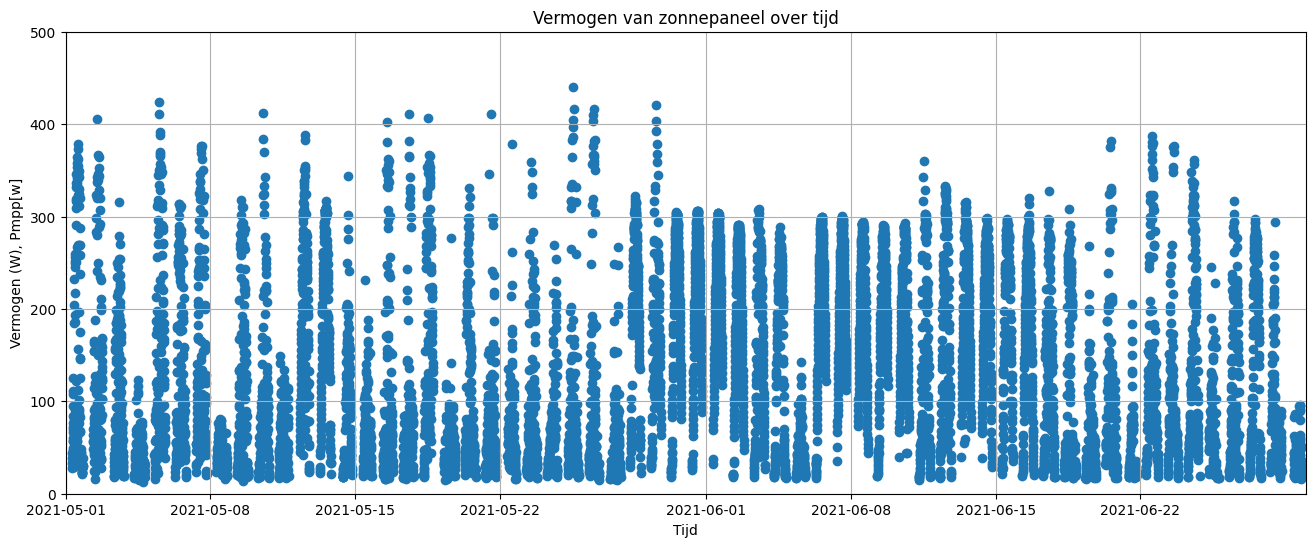

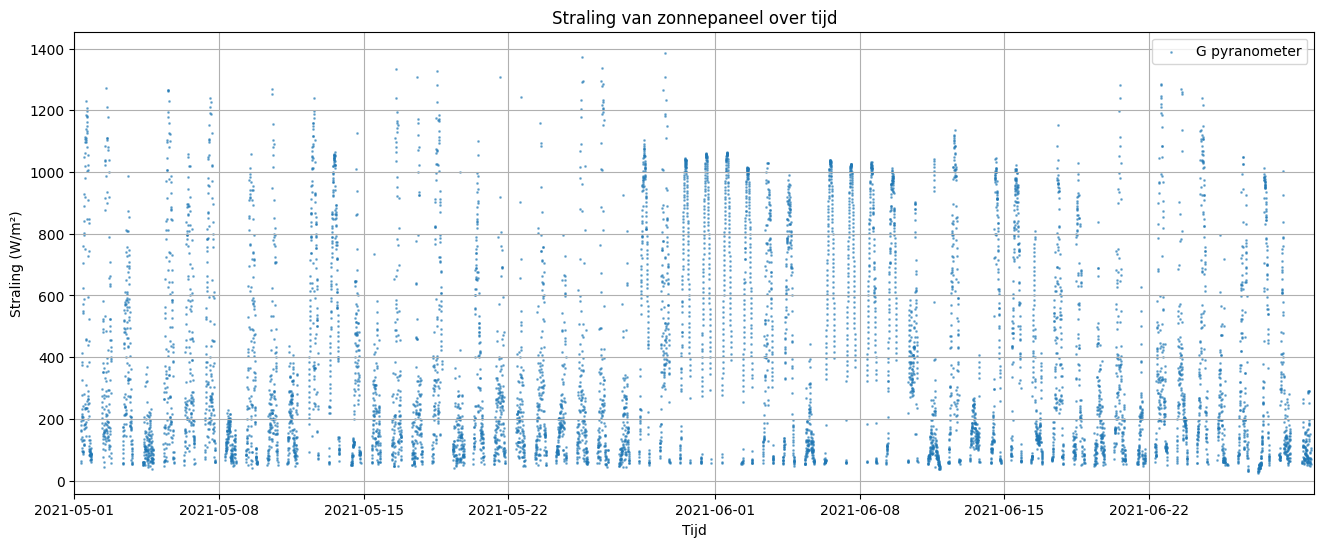

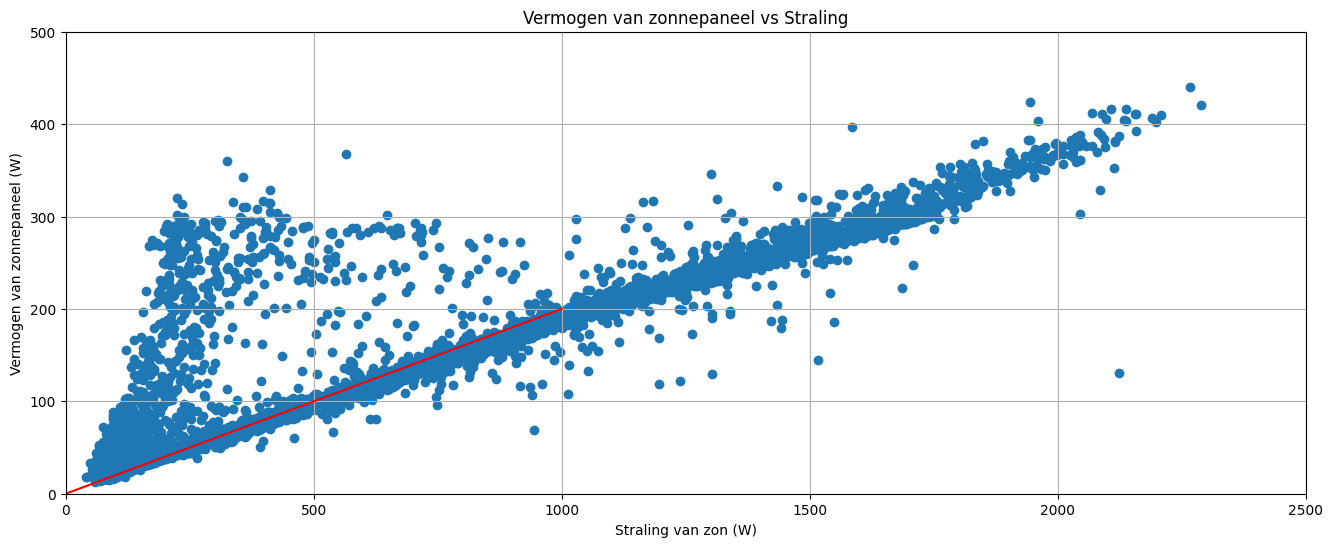

In [10]:
%matplotlib inline
begin = pd.Timestamp('2021-05-01')
end = pd.Timestamp('2021-6-30')

import matplotlib.pyplot as plt
plt.figure(figsize=(16, 6))
plt.scatter(synced_df.index, synced_df['Pmpp[W]_3 (Solarpanel parameters)'])
plt.xlabel('Tijd')
plt.ylabel('Vermogen (W), Pmpp[w]')
plt.title('Vermogen van zonnepaneel over tijd')
plt.xlim(begin,end)
plt.ylim(0,500)
plt.grid()

plt.show()
plt.figure(figsize=(16, 6))
#plt.scatter(synced_df.index, synced_df['Pmpp[W]_3 (Solarpanel parameters)'],alpha=0.5,s=0.1)
#plt.scatter(synced_df.index, synced_df['G[W/mï½²]_3 (Solarpanel parameters)'],alpha=0.5,s=1,label='G paneel')
plt.scatter(synced_df.index, synced_df['G_pyranometer[W/mï½²]_3 (Solarpanel parameters)'],alpha=0.5,s=1, label='G pyranometer')
plt.xlabel('Tijd')
plt.ylabel('Straling (W/m²)')
plt.title('Straling van zonnepaneel over tijd')
plt.xlim(begin,end)
plt.grid()
plt.legend()
plt.show()

begin_rendement = begin #pd.Timestamp('2021-05-1')
end_rendement = end #pd.Timestamp('2021-06-30')

maandenchecken = synced_df.loc[begin_rendement:end_rendement].copy()

plt.figure(figsize=(16, 6))
plt.scatter(maandenchecken['G_pyranometer[W/mï½²]_3 (Solarpanel parameters)']*1.65,maandenchecken['Pmpp[W]_3 (Solarpanel parameters)'])
x = np.linspace(0, 1000, 100)
plt.plot(x, x*0.20, 'r')
plt.xlabel('Straling van zon (W)')
plt.ylabel('Vermogen van zonnepaneel (W)')
plt.title('Vermogen van zonnepaneel vs Straling')
plt.grid()
plt.xlim(0,2500)
plt.ylim(0,500)
plt.show()

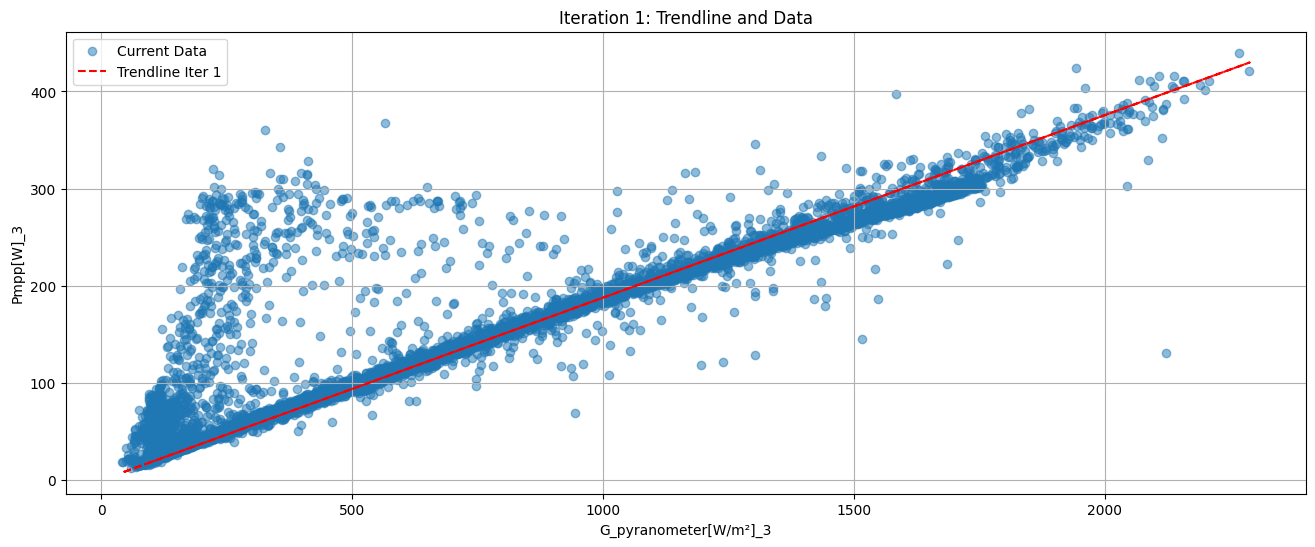

Iteration 1: y = 0.19x
Iteration 1: Removed 326 outliers.


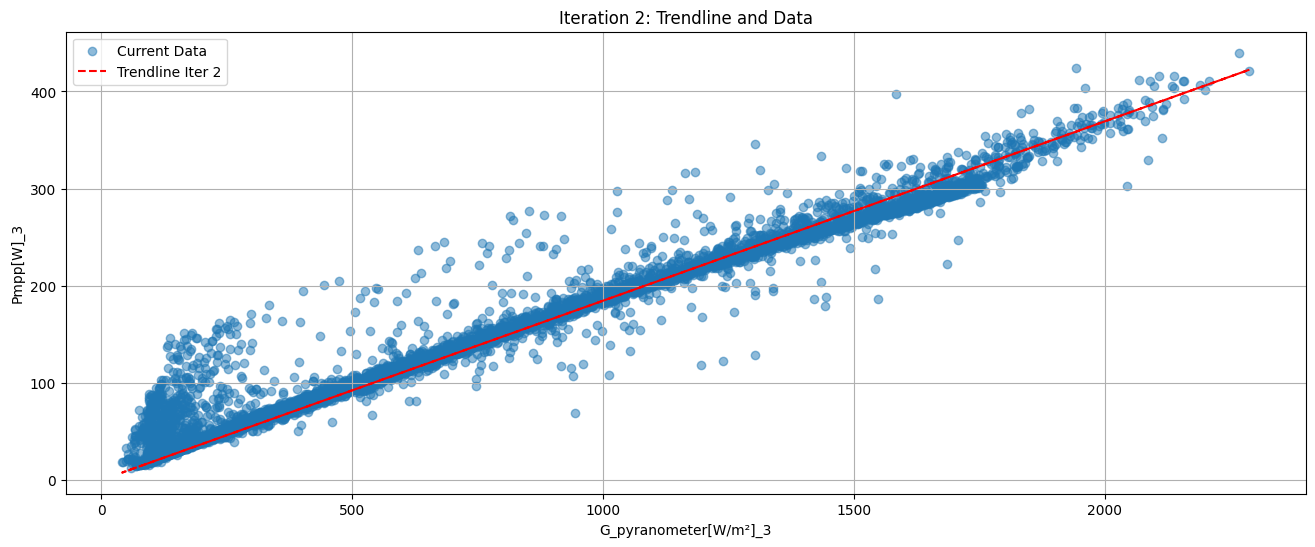

Iteration 2: y = 0.18x
Iteration 2: Removed 262 outliers.


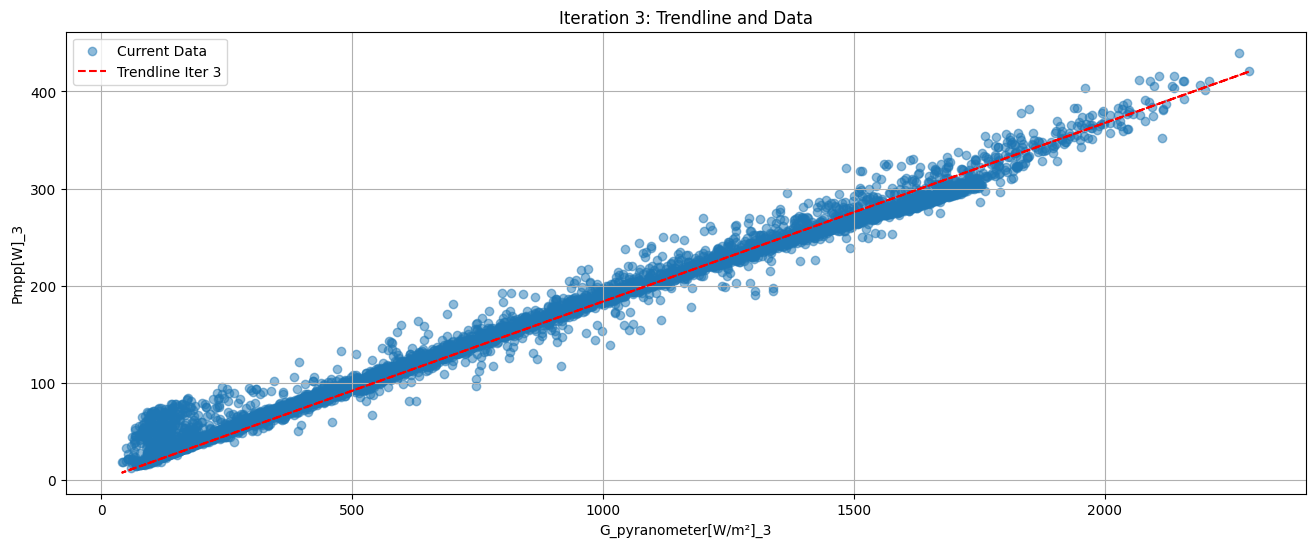

Iteration 3: y = 0.18x
Iteration 3: Removed 254 outliers.


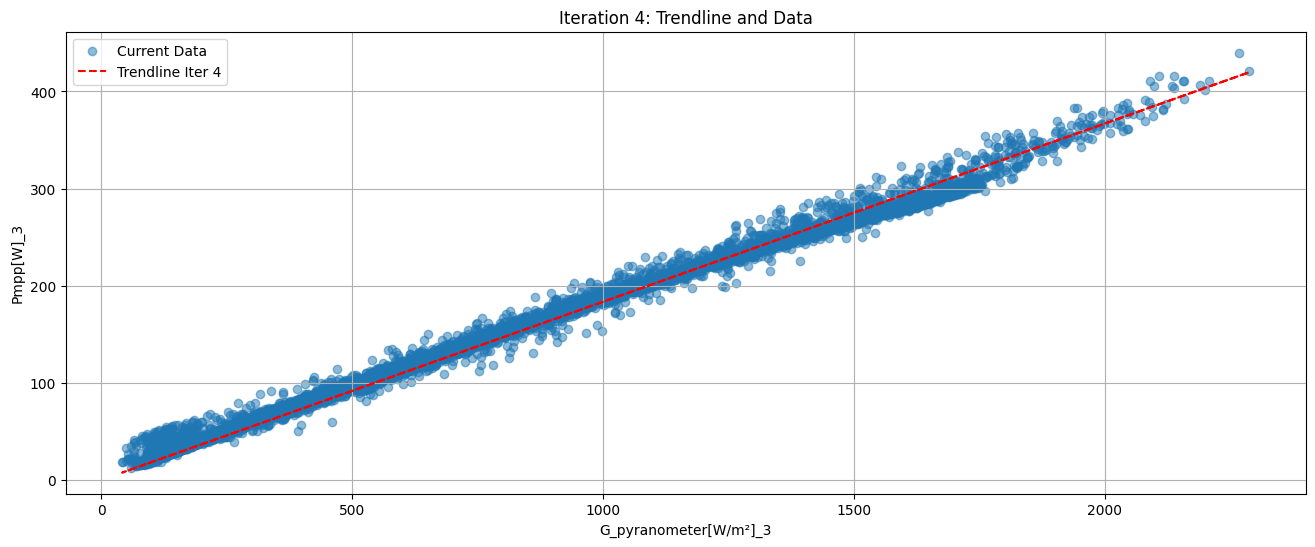

Iteration 4: y = 0.18x
Iteration 4: Removed 130 outliers.


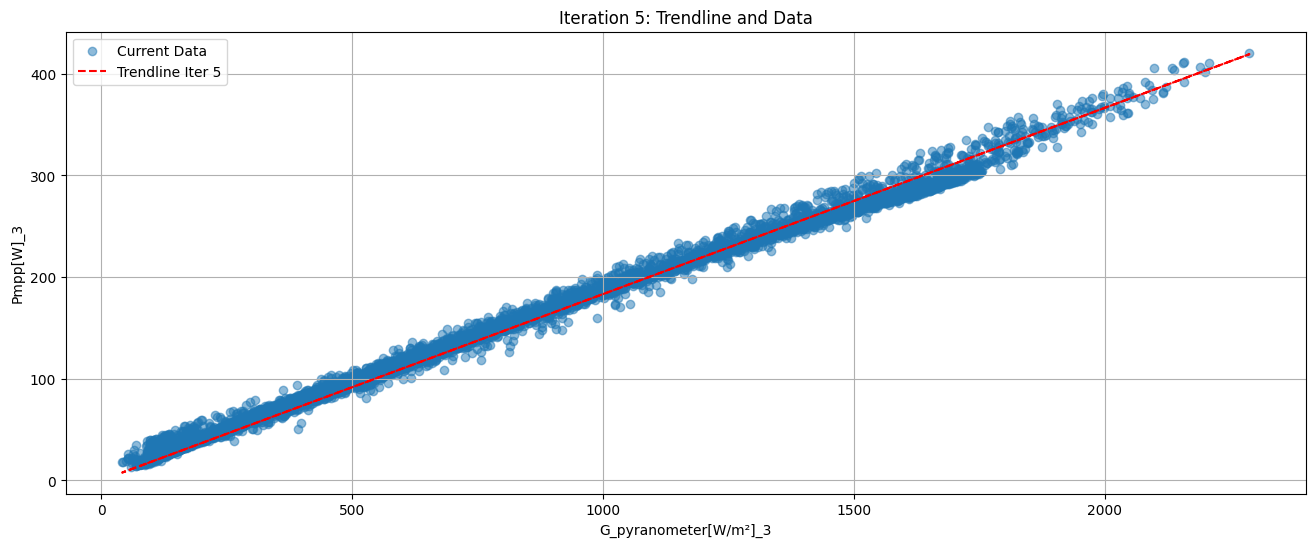

Iteration 5: y = 0.18x
Iteration 5: Removed 51 outliers.


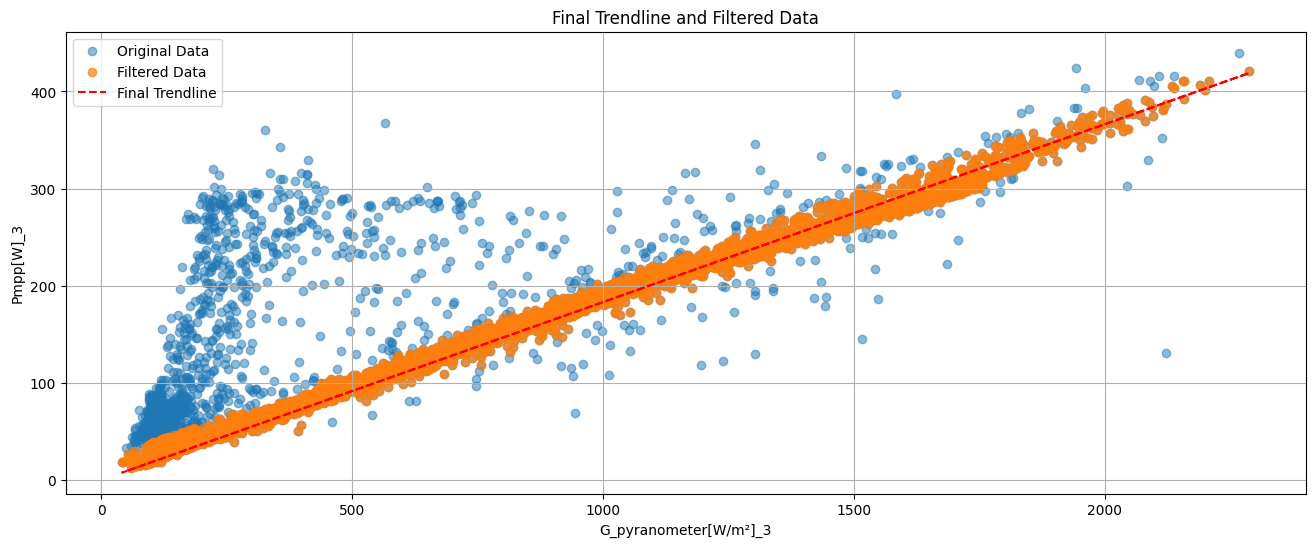

Final Trendline: y = 0.18x


,AbsTime[s],Act Air Density (WeatherStation),Act Wind Direction (WeatherStation),Act Wind Measurement Quality (WeatherStation),Act Wind Speed [km/h] (WeatherStation),Avg Absolute Air Pressure (WeatherStation),Avg Air Temperature (WeatherStation),Avg Dewpoint Temperature (WeatherStation),Avg Relative Humidity (WeatherStation),Avg Wind Speed [km/h] (WeatherStation),...,Temperature [°C] (LAD Sensor 12),Gain (LAD Sensor 12),Integration time (LAD Sensor 12),Year,Month,Day,Weekday,Time,x,y
datetime,,,,,,,,,,,,,,,,,,,,,
2021-05-01 07:40:00,3828843600,1.254171,274.9478,100.0,1.263555,1014.983,7.849673,4.481034,79.27757,0.000000,...,12.5,0.0,192.0,2021,May,1,Saturday,07:40:00,92.070,27.769
2021-05-01 07:45:00,3828843900,1.253278,0.0000,100.0,0.000000,1015.017,7.985149,4.476882,78.52754,0.000000,...,13.2,0.0,192.0,2021,May,1,Saturday,07:45:00,103.950,33.301
2021-05-01 07:50:00,3828844200,1.252931,215.4218,100.0,3.023074,1015.103,8.223319,4.593984,77.90422,1.735225,...,14.2,0.0,192.0,2021,May,1,Saturday,07:50:00,264.165,39.011
2021-05-01 07:55:00,3828844500,1.252172,252.3136,100.0,1.941241,1015.179,8.188429,4.462746,77.37485,1.371645,...,15.8,0.0,192.0,2021,May,1,Saturday,07:55:00,222.255,43.629
2021-05-01 08:00:00,3828844800,1.252115,0.0000,100.0,1.385355,1015.175,8.324501,4.452083,76.60724,1.420834,...,17.0,0.0,192.0,2021,May,1,Saturday,08:00:00,272.415,49.097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-29 19:25:00,3833983500,1.209372,187.6491,100.0,5.572020,1013.254,16.917380,14.182340,83.93651,2.328395,...,20.5,0.0,192.0,2021,June,29,Tuesday,19:25:00,251.460,50.037
2021-06-29 19:30:00,3833983800,1.208927,299.8468,100.0,2.882967,1013.286,17.031370,14.230000,83.59035,3.331224,...,21.5,0.0,192.0,2021,June,29,Tuesday,19:30:00,115.170,23.053
2021-06-29 19:35:00,3833984100,1.208520,238.2829,100.0,6.478311,1013.278,17.091160,14.268260,83.48077,1.996748,...,21.8,0.0,192.0,2021,June,29,Tuesday,19:35:00,173.580,35.219


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming `synced_df` is already defined
begin_rendement = begin  # Replace `begin` with your actual start timestamp
end_rendement = end      # Replace `end` with your actual end timestamp

# Extract data for the specified time range
maandenchecken = synced_df.loc[begin_rendement:end_rendement].copy()

# Extract x and y values
x = maandenchecken['G_pyranometer[W/mï½²]_3 (Solarpanel parameters)'] * 1.65
y = maandenchecken['Pmpp[W]_3 (Solarpanel parameters)']

# Add x and y columns to maandenchecken for tracking
maandenchecken['x'] = x
maandenchecken['y'] = y

# Function to iteratively fit and remove outliers (slope-only)
def iterative_fit_and_filter(data, x_col, y_col, threshold=3, max_iterations=5):
    x = pd.to_numeric(data[x_col], errors='coerce')
    y = pd.to_numeric(data[y_col], errors='coerce')

    # Remove initial NaN values
    mask = ~x.isna() & ~y.isna()
    x = x[mask]
    y = y[mask]
    filtered_data = data[mask].copy()

    for iteration in range(max_iterations):
        # Fit a slope-only line (zero-intercept)
        slope = np.sum(x * y) / np.sum(x ** 2)
        
        # Calculate residuals
        residuals = y - (slope * x)
        std_residuals = np.std(residuals)

        # Identify points far from the trendline
        outliers = np.abs(residuals) > threshold * std_residuals

        if not outliers.any():
            print(f"No more outliers found after {iteration} iterations.")
            break

        # Plot intermediate results
        plt.figure(figsize=(16, 6))
        plt.scatter(x, y, alpha=0.5, label='Current Data')
        plt.plot(x, slope * x, "r--", label=f'Trendline Iter {iteration + 1}')
        plt.xlabel('G_pyranometer[W/m²]_3')
        plt.ylabel('Pmpp[W]_3')
        plt.title(f'Iteration {iteration + 1}: Trendline and Data')
        plt.legend()
        plt.grid()
        plt.show()

        # Print equation of the line
        print(f"Iteration {iteration + 1}: y = {slope:.2f}x")

        # Remove outliers
        filtered_mask = ~outliers
        x = x[filtered_mask]
        y = y[filtered_mask]
        filtered_data = filtered_data[filtered_mask].copy()

        print(f"Iteration {iteration + 1}: Removed {outliers.sum()} outliers.")

    # Final fit (slope-only)
    final_slope = np.sum(x * y) / np.sum(x ** 2)

    # Plot final results
    plt.figure(figsize=(16, 6))
    plt.scatter(data[x_col], data[y_col], alpha=0.5, label='Original Data')
    plt.scatter(x, y, alpha=0.7, label='Filtered Data')
    plt.plot(x, final_slope * x, "r--", label='Final Trendline')
    plt.xlabel('G_pyranometer[W/m²]_3')
    plt.ylabel('Pmpp[W]_3')
    plt.title('Final Trendline and Filtered Data')
    plt.legend()
    plt.grid()
    plt.show()

    # Print final equation of the line
    print(f"Final Trendline: y = {final_slope:.2f}x")

    return filtered_data, final_slope

# Apply the function
filtered_df, final_slope = iterative_fit_and_filter(maandenchecken, 'x', 'y')

# Display filtered DataFrame
filtered_df


In [16]:
import pvlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def simulatie_runnen(
    df,
    kalibratie_waarde=31.67,
    locatie_naam="amolf",
    latitude=52.3676,
    longitude=4.9041,
    timezone="Europe/Amsterdam",
    surface_tilt=45,
    surface_azimuth=180,
    albedo=0.2
):
    # PVWatts parameters
    pdc0 = 255
    gamma_pdc = -0.0045
    
    # Set up location
    location = pvlib.location.Location(
        latitude=latitude, longitude=longitude, tz=timezone, name=locatie_naam
    )
    
    # Copy the input DataFrame
    data = df.copy()
    
    # Calculate solar position
    solar_position = location.get_solarposition(data.index)
    
    # Calculate DNI and DHI from GHI
    dni = pvlib.irradiance.dirint(
        ghi=data["G_pyranometer[W/mï½²]_3 (Solarpanel parameters)"],
        solar_zenith=solar_position["apparent_zenith"],
        times=data.index
    )
    dhi = data["G_pyranometer[W/mï½²]_3 (Solarpanel parameters)"] - dni * np.cos(np.radians(solar_position["apparent_zenith"]))
    
    # Calculate POA irradiance using panel tilt and azimuth
    poa_irradiance = pvlib.irradiance.get_total_irradiance(
        surface_tilt=surface_tilt,
        surface_azimuth=surface_azimuth,
        solar_zenith=solar_position["apparent_zenith"],
        solar_azimuth=solar_position["azimuth"],
        dni=dni,
        ghi=data["G_pyranometer[W/mï½²]_3 (Solarpanel parameters)"],
        dhi=dhi,
        albedo=albedo
    )
    
    # Add POA irradiance to weather data
    data["poa_irradiance"] = poa_irradiance["poa_global"]
    
    # Temperature model parameters for open-rack glass-glass panels
    from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
    temperature_model_parameters = TEMPERATURE_MODEL_PARAMETERS["sapm"]["open_rack_glass_glass"]
    
    # Define the PV system
    system = pvlib.pvsystem.PVSystem(
        surface_tilt=surface_tilt,
        surface_azimuth=surface_azimuth,
        module_parameters={"pdc0": pdc0, "gamma_pdc": gamma_pdc},
        inverter_parameters={"pdc0": pdc0},
        temperature_model_parameters=temperature_model_parameters
    )
    
    # Weather data preparation
    weather = pd.DataFrame(index=data.index)
    weather["ghi"] = data["G_pyranometer[W/mï½²]_3 (Solarpanel parameters)"]
    weather["dni"] = dni
    weather["dhi"] = dhi
    weather["temp_air"] = data.get("Avg Air Temperature (WeatherStation)", 20.0)
    weather["wind_speed"] = data.get("Avg Wind Speed [km/h] (WeatherStation)", 3.6) / 3.6
    weather["poa_global"] = data["poa_irradiance"]
    
    # Run the model chain
    mc = pvlib.modelchain.ModelChain(
        system, location, dc_model="pvwatts", ac_model="pvwatts",
        aoi_model="physical", spectral_model="no_loss"
    )
    mc.run_model(weather)
    
    # Calibrate DC output
    dc_power = mc.results.dc * kalibratie_waarde
    return dc_power

In [18]:
dc_vermogen_0_azimuth = simulatie_runnen(filtered_df,surface_azimuth=180, surface_tilt=0)
dc_vermogen_180_azimuth = simulatie_runnen(filtered_df,surface_azimuth=180, surface_tilt=45)

In [19]:
dc_vermogen_0_azimuth

datetime
2021-05-01 07:40:00     481.550179
2021-05-01 07:45:00     542.813114
2021-05-01 07:50:00    1359.444233
2021-05-01 07:55:00    1148.075655
2021-05-01 08:00:00    1400.144543
                          ...     
2021-06-29 19:25:00    1139.361488
2021-06-29 19:30:00     435.168166
2021-06-29 19:35:00     780.451171
2021-06-29 19:40:00     803.844241
2021-06-29 19:45:00     451.264802
Name: p_mp, Length: 7379, dtype: float64

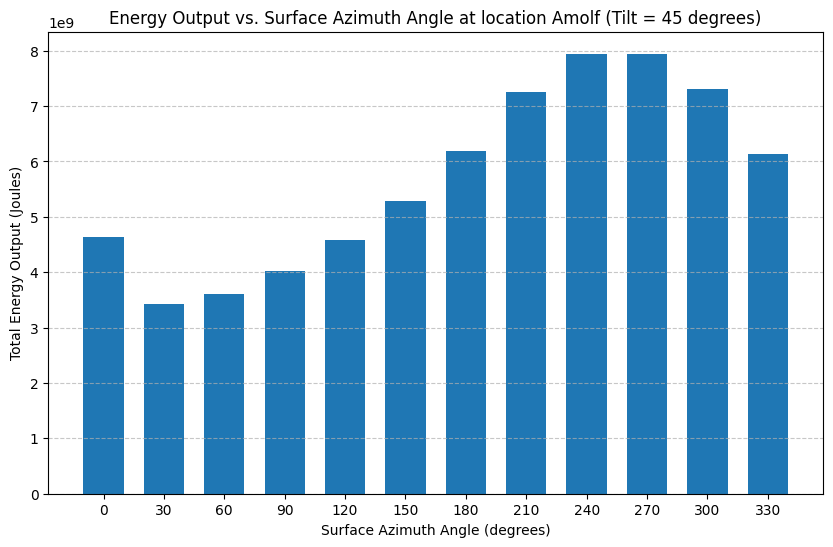

In [32]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the range of azimuth angles to test
azimuths = np.arange(0, 360, 30)  # Azimuth angles from 0 to 360 degrees with 30-degree steps

# Fixed tilt angle for testing
fixed_tilt = 45  # Example tilt angle (adjust as needed)

# List to store results
results = []

# Loop through all azimuth angles
for azimuth in azimuths:
    # Run the simulation with the current azimuth and fixed tilt
    dc_power_df = simulatie_runnen(filtered_df, surface_azimuth=azimuth, surface_tilt=fixed_tilt)
    
    # Ensure the result is in DataFrame format
    if isinstance(dc_power_df, str):
        from io import StringIO
        dc_power_df = pd.read_csv(StringIO(dc_power_df))
    
    # Compute total energy output (sum of power over time in Joules)
    total_energy = dc_power_df.sum() * 60 * 5  # Assuming 5-minute intervals, convert to Joules
    total_energy_value = total_energy.values[0] if isinstance(total_energy, pd.Series) else total_energy
    
    # Append results as a tuple of azimuth and total energy
    results.append((azimuth, total_energy_value))

# Convert results into a DataFrame for easier processing
results_df = pd.DataFrame(results, columns=["Azimuth", "Total Energy (Joules)"])

# Create a bar plot to visualize the results
plt.figure(figsize=(10, 6))
plt.bar(results_df["Azimuth"], results_df["Total Energy (Joules)"], width=20, align="center")
plt.xlabel("Surface Azimuth Angle (degrees)")
plt.ylabel("Total Energy Output (Joules)")
plt.title("Energy Output vs. Surface Azimuth Angle at location Amolf (Tilt = 45 degrees)")
plt.xticks(results_df["Azimuth"])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


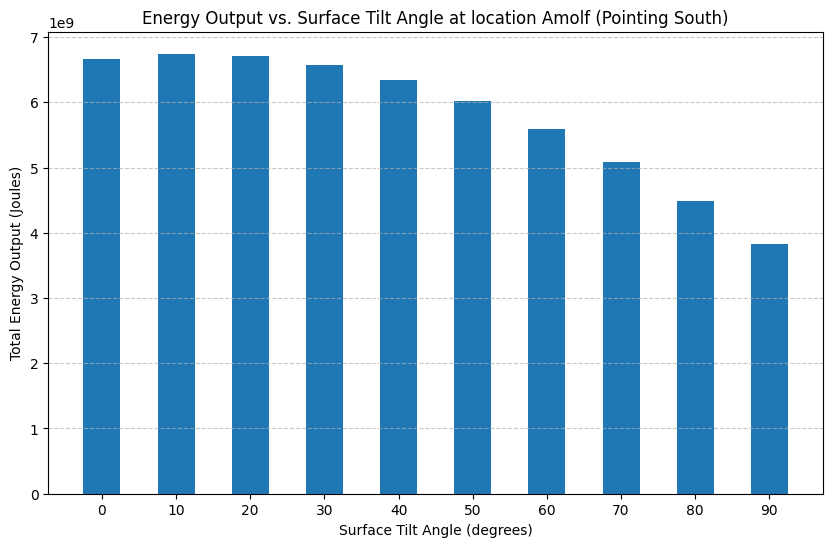

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the range of tilt angles to test
tilts = np.arange(0, 91, 10)  # Tilt angles from 0 to 90 degrees with 10-degree steps

# Fixed azimuth angle for testing
fixed_azimuth = 180  # Example azimuth angle (adjust as needed)

# List to store results
results = []

# Loop through all tilt angles
for tilt in tilts:
    # Run the simulation with the current tilt and fixed azimuth
    dc_power_df = simulatie_runnen(filtered_df, surface_azimuth=fixed_azimuth, surface_tilt=tilt)
    
    # Ensure the result is in DataFrame format
    if isinstance(dc_power_df, str):
        from io import StringIO
        dc_power_df = pd.read_csv(StringIO(dc_power_df))
    
    # Compute total energy output (sum of power over time in Joules)
    total_energy = dc_power_df.sum() * 60 * 5  # Assuming 5-minute intervals, convert to Joules
    total_energy_value = total_energy.values[0] if isinstance(total_energy, pd.Series) else total_energy
    
    # Append results as a tuple of tilt and total energy
    results.append((tilt, total_energy_value))

# Convert results into a DataFrame for easier processing
results_df = pd.DataFrame(results, columns=["Tilt", "Total Energy (Joules)"])

# Create a bar plot to visualize the results
plt.figure(figsize=(10, 6))
plt.bar(results_df["Tilt"], results_df["Total Energy (Joules)"], width=5, align="center")
plt.xlabel("Surface Tilt Angle (degrees)")
plt.ylabel("Total Energy Output (Joules)")
plt.title("Energy Output vs. Surface Tilt Angle at location Amolf (Pointing South)")
plt.xticks(results_df["Tilt"])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [54]:
%matplotlib qt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define ranges for azimuth and tilt angles
azimuths = np.arange(252, 258, 0.5)  # Azimuth angles from 0 to 360 degrees in 30-degree steps
tilts = np.arange(37, 43, 0.5)      # Tilt angles from 0 to 90 degrees in 10-degree steps

# Create a grid for azimuth and tilt
azimuth_grid, tilt_grid = np.meshgrid(azimuths, tilts)

# Placeholder for energy output
energy_output = np.zeros_like(azimuth_grid, dtype=float)

# Compute energy output for each combination of azimuth and tilt
for i, azimuth in enumerate(azimuths):
    for j, tilt in enumerate(tilts):
        # Run simulation for each azimuth-tilt combination
        dc_power_df = simulatie_runnen(filtered_df, surface_azimuth=azimuth, surface_tilt=tilt)
        
        # Ensure the result is in DataFrame format
        if isinstance(dc_power_df, str):
            from io import StringIO
            dc_power_df = pd.read_csv(StringIO(dc_power_df))
        
        # Compute total energy (sum of power over time in Joules)
        total_energy = dc_power_df.sum() * 60 * 5  # Assuming 5-minute intervals, convert to Joules
        total_energy_value = total_energy.values[0] if isinstance(total_energy, pd.Series) else total_energy
        
        # Store the result in the energy output grid
        energy_output[j, i] = total_energy_value

# Create a 3D surface plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(
    azimuth_grid, tilt_grid, energy_output, cmap="viridis", edgecolor="k", alpha=0.8
)

# Add labels and title
ax.set_xlabel("Surface Azimuth Angle (degrees)")
ax.set_ylabel("Surface Tilt Angle (degrees)")
ax.set_zlabel("Total Energy Output (Joules)")
ax.set_title("Energy Output vs. Surface Azimuth and Tilt Angles at Location Amolf")

# Add a color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label="Energy Output (Joules)")

# Show the plot
plt.show()


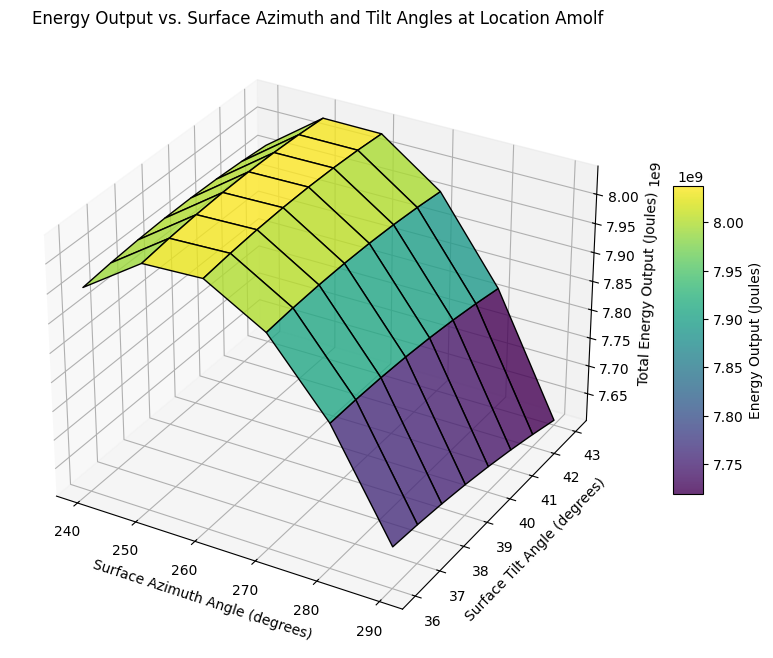

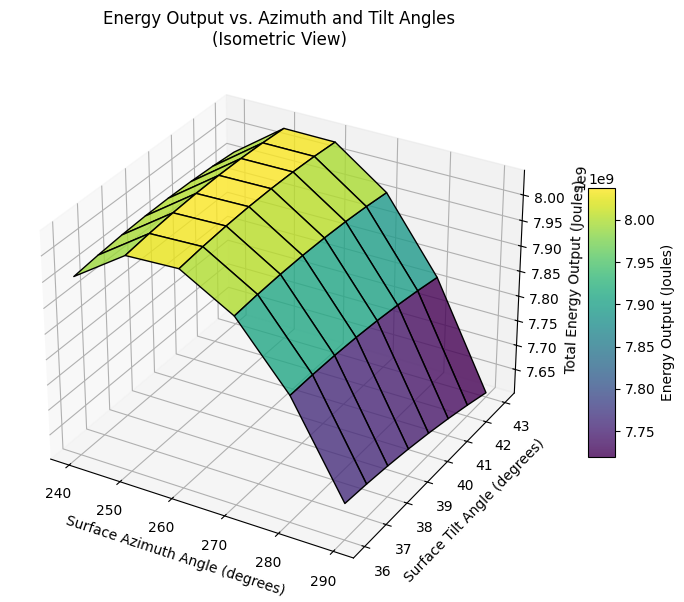

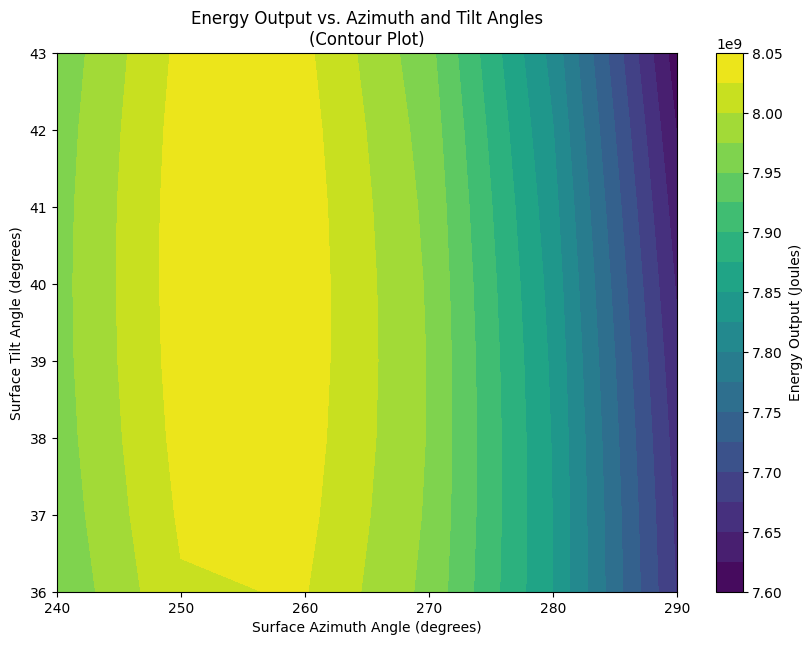

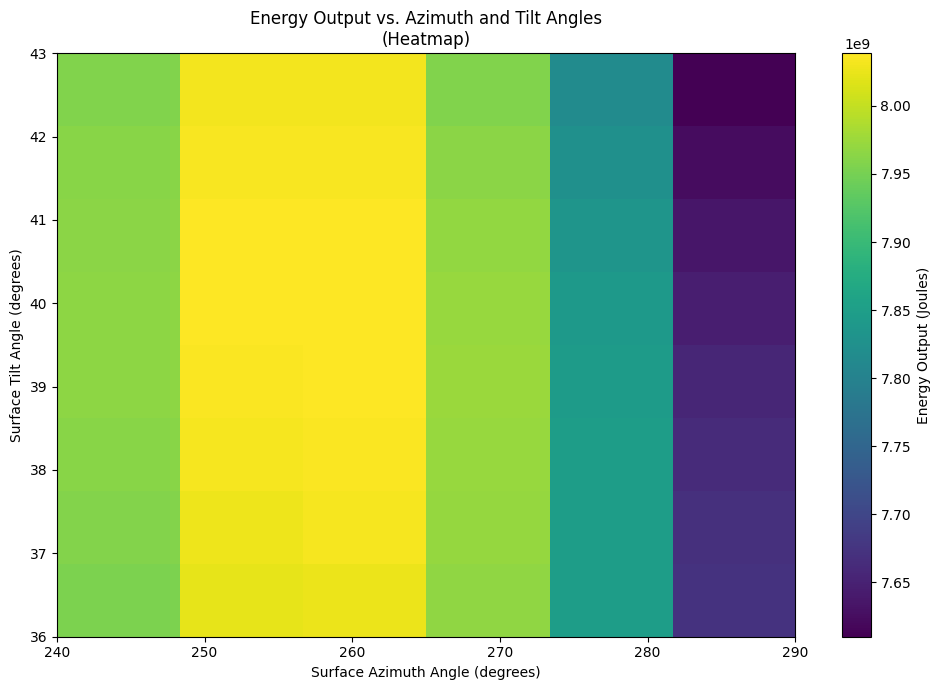

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Replace `azimuth_grid`, `tilt_grid`, and `energy_output` with your actual data
# Assuming these variables contain your data from the previous computations

# 1. Isometric View of 3D Surface
fig1 = plt.figure(figsize=(10, 7))
ax1 = fig1.add_subplot(111, projection='3d')
surf1 = ax1.plot_surface(
    azimuth_grid, tilt_grid, energy_output, cmap="viridis", edgecolor="k", alpha=0.8
)
ax1.set_xlabel("Surface Azimuth Angle (degrees)")
ax1.set_ylabel("Surface Tilt Angle (degrees)")
ax1.set_zlabel("Total Energy Output (Joules)")
ax1.set_title("Energy Output vs. Azimuth and Tilt Angles\n(Isometric View)")
fig1.colorbar(surf1, ax=ax1, shrink=0.5, aspect=10, label="Energy Output (Joules)")

# 2. Contour Plot
fig2, ax2 = plt.subplots(figsize=(10, 7))
contour = ax2.contourf(azimuth_grid, tilt_grid, energy_output, levels=20, cmap="viridis")
cbar = plt.colorbar(contour, ax=ax2)
cbar.set_label("Energy Output (Joules)")
ax2.set_xlabel("Surface Azimuth Angle (degrees)")
ax2.set_ylabel("Surface Tilt Angle (degrees)")
ax2.set_title("Energy Output vs. Azimuth and Tilt Angles\n(Contour Plot)")

# 3. Heatmap
fig3, ax3 = plt.subplots(figsize=(10, 7))
heatmap = ax3.imshow(
    energy_output,
    extent=[azimuths.min(), azimuths.max(), tilts.min(), tilts.max()],
    origin="lower",
    aspect="auto",
    cmap="viridis",
)
cbar = plt.colorbar(heatmap, ax=ax3)
cbar.set_label("Energy Output (Joules)")
ax3.set_xlabel("Surface Azimuth Angle (degrees)")
ax3.set_ylabel("Surface Tilt Angle (degrees)")
ax3.set_title("Energy Output vs. Azimuth and Tilt Angles\n(Heatmap)")

plt.tight_layout()
plt.show()


Optimal for Maastricht:
  Optimal Tilt: 40 degrees
  Optimal Azimuth: 270 degrees
  Maximum Energy Output: 8018372606.16 Joules


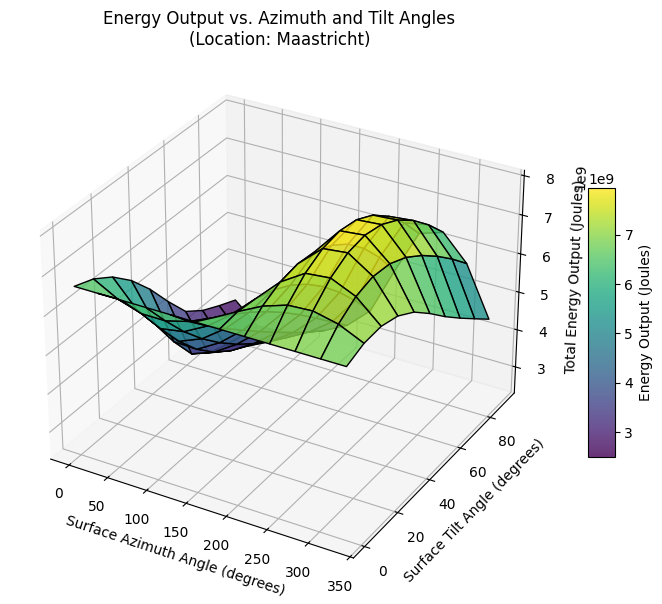

Optimal for Groningen:
  Optimal Tilt: 40 degrees
  Optimal Azimuth: 270 degrees
  Maximum Energy Output: 8067625565.62 Joules


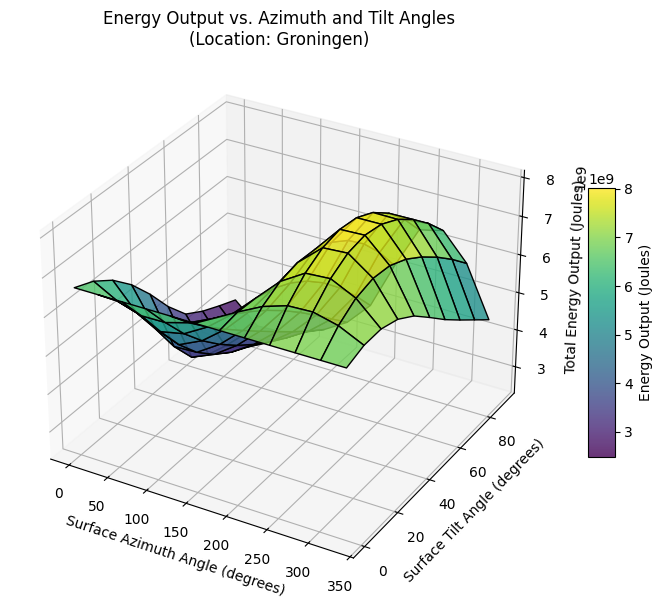

In [37]:
# Define coordinates for the selected cities
locations = {
    "Maastricht": {"latitude": 50.8514, "longitude": 5.6900},
    "Groningen": {"latitude": 53.2194, "longitude": 6.5665},
}

# Iterate through the two locations
for city, coords in locations.items():
    # Update latitude and longitude for the simulation
    latitude = coords["latitude"]
    longitude = coords["longitude"]
    
    # Placeholder for energy output
    energy_output = np.zeros_like(azimuth_grid, dtype=float)
    
    # Simulate for each combination of azimuth and tilt
    for i, azimuth in enumerate(azimuths):
        for j, tilt in enumerate(tilts):
            # Run the simulation with updated location
            dc_power_df = simulatie_runnen(
                filtered_df,
                surface_azimuth=azimuth,
                surface_tilt=tilt,
                latitude=latitude,
                longitude=longitude,
            )
            
            # Ensure the result is in DataFrame format
            if isinstance(dc_power_df, str):
                from io import StringIO
                dc_power_df = pd.read_csv(StringIO(dc_power_df))
            
            # Compute total energy (sum of power over time in Joules)
            total_energy = dc_power_df.sum() * 60 * 5  # Assuming 5-minute intervals
            total_energy_value = total_energy.values[0] if isinstance(total_energy, pd.Series) else total_energy
            
            # Store the result in the energy output grid
            energy_output[j, i] = total_energy_value
    
    # Find optimal tilt and azimuth
    max_energy_index = np.unravel_index(np.argmax(energy_output), energy_output.shape)
    optimal_tilt = tilts[max_energy_index[0]]
    optimal_azimuth = azimuths[max_energy_index[1]]
    max_energy = energy_output[max_energy_index]
    
    # Print optimal values
    print(f"Optimal for {city}:")
    print(f"  Optimal Tilt: {optimal_tilt} degrees")
    print(f"  Optimal Azimuth: {optimal_azimuth} degrees")
    print(f"  Maximum Energy Output: {max_energy:.2f} Joules")
    
    # Generate 3D Plot for the location
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(
        azimuth_grid, tilt_grid, energy_output, cmap="viridis", edgecolor="k", alpha=0.8
    )
    ax.set_xlabel("Surface Azimuth Angle (degrees)")
    ax.set_ylabel("Surface Tilt Angle (degrees)")
    ax.set_zlabel("Total Energy Output (Joules)")
    ax.set_title(f"Energy Output vs. Azimuth and Tilt Angles\n(Location: {city})")
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label="Energy Output (Joules)")
    plt.show()


In [44]:
# Define refined ranges for tilt and azimuth
tilts = np.arange(38, 42.5, 0.5)  # Tilt angles from 38 to 42 degrees in 0.5-degree steps
azimuths = np.arange(250, 266, 2)  # Azimuth angles from 250 to 265 degrees in 2-degree steps

# Create a grid for azimuth and tilt
azimuth_grid, tilt_grid = np.meshgrid(azimuths, tilts)

# Define coordinates for the selected cities, including AMOLF
locations = {
    "Maastricht": {"latitude": 50.8514, "longitude": 5.6900},
    "Groningen": {"latitude": 53.2194, "longitude": 6.5665},
    "AMOLF": {"latitude": 52.3676, "longitude": 4.9041},  # Amsterdam, AMOLF location
}

# Iterate through the three locations
for city, coords in locations.items():
    # Update latitude and longitude for the simulation
    latitude = coords["latitude"]
    longitude = coords["longitude"]
    
    # Placeholder for energy output
    energy_output = np.zeros_like(azimuth_grid, dtype=float)
    
    # Simulate for each combination of azimuth and tilt
    for i, azimuth in enumerate(azimuths):
        for j, tilt in enumerate(tilts):
            # Run the simulation with updated location
            dc_power_df = simulatie_runnen(
                filtered_df,
                surface_azimuth=azimuth,
                surface_tilt=tilt,
                latitude=latitude,
                longitude=longitude,
            )
            
            # Ensure the result is in DataFrame format
            if isinstance(dc_power_df, str):
                from io import StringIO
                dc_power_df = pd.read_csv(StringIO(dc_power_df))
            
            # Compute total energy (sum of power over time in Joules)
            total_energy = dc_power_df.sum() * 60 * 5  # Assuming 5-minute intervals
            total_energy_value = total_energy.values[0] if isinstance(total_energy, pd.Series) else total_energy
            
            # Store the result in the energy output grid
            energy_output[j, i] = total_energy_value
    
    # Find optimal tilt and azimuth
    max_energy_index = np.unravel_index(np.argmax(energy_output), energy_output.shape)
    optimal_tilt = tilts[max_energy_index[0]]
    optimal_azimuth = azimuths[max_energy_index[1]]
    max_energy = energy_output[max_energy_index]
    
    # Print optimal values
    print(f"Optimal for {city}:")
    print(f"  Optimal Tilt: {optimal_tilt:.2f} degrees")
    print(f"  Optimal Azimuth: {optimal_azimuth:.2f} degrees")
    print(f"  Maximum Energy Output: {max_energy:.2f} Joules")
    
    # Generate 3D Plot for the location
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(
        azimuth_grid, tilt_grid, energy_output, cmap="viridis", edgecolor="k", alpha=0.8
    )
    ax.set_xlabel("Surface Azimuth Angle (degrees)")
    ax.set_ylabel("Surface Tilt Angle (degrees)")
    ax.set_zlabel("Total Energy Output (Joules)")
    ax.set_title(f"Energy Output vs. Azimuth and Tilt Angles\n(Location: {city})")
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label="Energy Output (Joules)")
    plt.show()


Optimal for Maastricht:
  Optimal Tilt: 40.50 degrees
  Optimal Azimuth: 258.00 degrees
  Maximum Energy Output: 8070013167.01 Joules
Optimal for Groningen:
  Optimal Tilt: 41.50 degrees
  Optimal Azimuth: 256.00 degrees
  Maximum Energy Output: 8138581709.40 Joules
Optimal for AMOLF:
  Optimal Tilt: 40.00 degrees
  Optimal Azimuth: 256.00 degrees
  Maximum Energy Output: 8046498545.16 Joules


In [72]:
%matplotlib inline

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define province locations (latitude and longitude) as in your simulation
province_locations = {
    "Drenthe": {"city": "Assen", "latitude": 52.9929, "longitude": 6.5642},
    "Flevoland": {"city": "Lelystad", "latitude": 52.5185, "longitude": 5.4714},
    "Friesland": {"city": "Leeuwarden", "latitude": 53.2012, "longitude": 5.7999},
    "Gelderland": {"city": "Arnhem", "latitude": 51.9851, "longitude": 5.8987},
    "Groningen": {"city": "Groningen", "latitude": 53.2194, "longitude": 6.5665},
    "Limburg": {"city": "Maastricht", "latitude": 50.8514, "longitude": 5.6900},
    "North Brabant": {"city": "Den Bosch", "latitude": 51.6978, "longitude": 5.3037},
    "North Holland": {"city": "Haarlem", "latitude": 52.3874, "longitude": 4.6462},
    "Overijssel": {"city": "Zwolle", "latitude": 52.5168, "longitude": 6.0830},
    "South Holland": {"city": "The Hague", "latitude": 52.0705, "longitude": 4.3007},
    "Utrecht": {"city": "Utrecht", "latitude": 52.0907, "longitude": 5.1214},
    "Zeeland": {"city": "Middelburg", "latitude": 51.4988, "longitude": 3.6105},
}

# Define tilt and azimuth ranges
tilts = np.arange(36, 45, 1)  # Tilt angles from 38 to 42 degrees in 0.5-degree steps
azimuths = np.arange(250, 262, 1)  # Azimuth angles from 250 to 265 degrees in 2-degree steps

# Create grid for azimuth and tilt
azimuth_grid, tilt_grid = np.meshgrid(azimuths, tilts)

# Iterate through each province and plot 3D surface
for province, location in province_locations.items():
    latitude = location["latitude"]
    longitude = location["longitude"]
    
    # Placeholder for energy output for each grid point
    energy_output = np.zeros_like(azimuth_grid, dtype=float)
    
    # Simulate energy output for each tilt-azimuth combination
    for i, azimuth in enumerate(azimuths):
        for j, tilt in enumerate(tilts):
            # Replace this with your simulation function
            dc_power_df = simulatie_runnen(
                filtered_df,
                surface_azimuth=azimuth,
                surface_tilt=tilt,
                latitude=latitude,
                longitude=longitude,
            )
            
            # Ensure the result is in DataFrame format
            if isinstance(dc_power_df, str):
                from io import StringIO
                dc_power_df = pd.read_csv(StringIO(dc_power_df))
            
            # Compute total energy (sum of power over time in Joules)
            total_energy = dc_power_df.sum() * 60 * 5  # Assuming 5-minute intervals
            total_energy_value = total_energy.values[0] if isinstance(total_energy, pd.Series) else total_energy
            
            # Store the energy output
            energy_output[j, i] = total_energy_value
    
    # Plot 3D surface for the province
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection="3d")
    surf = ax.plot_surface(
        azimuth_grid,
        tilt_grid,
        energy_output,
        cmap="viridis",
        edgecolor="k",
        alpha=0.8
    )
    
    # Add labels and title
    ax.set_xlabel("Surface Azimuth Angle (degrees)")
    ax.set_ylabel("Surface Tilt Angle (degrees)")
    ax.set_zlabel("Total Energy Output (Joules)")
    ax.set_title(f"Energy Output vs. Azimuth and Tilt Angles\n(Location: {province})")
    
    # Add colorbar
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label="Energy Output (Joules)")
    
    # Show the plot
    plt.show()


In [75]:
%matplotlib qt

In [83]:
results_df

,Province,City,Optimal Tilt (degrees),Optimal Azimuth (degrees),Maximum Energy Output (Joules)
0,Drenthe,Assen,41.5,256,8.138706e+09
1,Flevoland,Lelystad,40.5,256,8.075077e+09
2,Friesland,Leeuwarden,41.0,256,8.103153e+09
3,Gelderland,Arnhem,41.0,256,8.094758e+09
4,Groningen,Groningen,41.5,256,8.138582e+09
5,Limburg,Maastricht,40.5,258,8.070013e+09
6,North Brabant,Den Bosch,40.5,256,8.060615e+09
7,North Holland,Haarlem,40.0,254,8.034290e+09
8,Overijssel,Zwolle,41.0,256,8.108235e+09
9,South Holland,The Hague,40.0,254,8.014576e+09


In [71]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import numpy as np

# Coordinates and values from your results
province_locations = {
    "Drenthe": {"latitude": 52.9929, "longitude": 6.5642},
    "Flevoland": {"latitude": 52.5185, "longitude": 5.4714},
    "Friesland": {"latitude": 53.2012, "longitude": 5.7999},
    "Gelderland": {"latitude": 51.9851, "longitude": 5.8987},
    "Groningen": {"latitude": 53.2194, "longitude": 6.5665},
    "Limburg": {"latitude": 50.8514, "longitude": 5.6900},
    "North Brabant": {"latitude": 51.6978, "longitude": 5.3037},
    "North Holland": {"latitude": 52.3874, "longitude": 4.6462},
    "Overijssel": {"latitude": 52.5168, "longitude": 6.0830},
    "South Holland": {"latitude": 52.0705, "longitude": 4.3007},
    "Utrecht": {"latitude": 52.0907, "longitude": 5.1214},
    "Zeeland": {"latitude": 51.4988, "longitude": 3.6105},
}
coordinates = [(loc["latitude"], loc["longitude"]) for loc in province_locations.values()]
values = [
    8.138706e9, 8.075077e9, 8.103153e9, 8.094758e9, 8.138582e9, 8.070013e9,
    8.060615e9, 8.034290e9, 8.108235e9, 8.014576e9, 8.053617e9, 7.972448e9
]

# Interpolation grid
lat_range = np.linspace(50.5, 53.5, 100)
lon_range = np.linspace(3.4, 7.2, 100)
lon_grid, lat_grid = np.meshgrid(lon_range, lat_range)

# Interpolate
grid_values = griddata(coordinates, values, (lat_grid, lon_grid), method="cubic")

# Plot the map with a background map
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={"projection": ccrs.PlateCarree()})
ax.set_extent([3.4, 7.2, 50.5, 53.5], crs=ccrs.PlateCarree())

# Add features to the map
ax.add_feature(cfeature.COASTLINE, edgecolor="black", linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black")
ax.add_feature(cfeature.LAND, facecolor="lightgray")
ax.add_feature(cfeature.OCEAN, facecolor="lightblue")
ax.add_feature(cfeature.LAKES, edgecolor="blue", facecolor="lightblue")

# Add interpolated heatmap
heatmap = ax.pcolormesh(
    lon_grid, lat_grid, grid_values, cmap="viridis", shading="auto", alpha=0.6, transform=ccrs.PlateCarree()
)

# Add a colorbar
plt.colorbar(heatmap, ax=ax, orientation="vertical", label="Maximum Energy Output (Joules)")

# Add red dots for provincial capitals
for province, (lat, lon) in zip(province_locations.keys(), coordinates):
    ax.plot(lon, lat, "o", color="red", label=f"{province}" if province not in ax.get_legend_handles_labels()[1] else "")

# Add title and legend
ax.set_title("Energy Output Distribution Over the Netherlands")
plt.legend(loc="lower left", title="Provincial Capitals")

# Display the plot
plt.show()


In [139]:
import numpy as np
import pandas as pd

# Define latitude and longitude range for the Netherlands
# Widen the longitude range and expand the latitude range slightly
latitudes = np.linspace(50.0, 55.0, 10)  # Increased latitude range (higher grid)
longitudes = np.linspace(2.0, 8.2, 10)  # Increased longitude range (wider grid)

# Define tilt and azimuth ranges
tilts = np.arange(38, 43, 1)  # Tilt angles from 38 to 42 degrees
azimuths = np.arange(250, 261, 1)  # Azimuth angles from 250 to 260 degrees

# Create a grid for latitude and longitude
lon_grid, lat_grid = np.meshgrid(longitudes, latitudes)

# Placeholder for results
grid_results = []

# Iterate over each grid point
for i, lat in enumerate(latitudes):
    for j, lon in enumerate(longitudes):
        # Placeholder for energy output for each grid point
        energy_output = np.zeros((len(tilts), len(azimuths)))

        # Simulate energy output for each tilt-azimuth combination
        for t, tilt in enumerate(tilts):
            for a, azimuth in enumerate(azimuths):
                # Replace this with your simulation function
                dc_power_df = simulatie_runnen(
                    filtered_df,
                    surface_azimuth=azimuth,
                    surface_tilt=tilt,
                    latitude=lat,
                    longitude=lon,
                )
                
                # Ensure the result is in DataFrame format
                if isinstance(dc_power_df, str):
                    from io import StringIO
                    dc_power_df = pd.read_csv(StringIO(dc_power_df))
                
                # Compute total energy (sum of power over time in Joules)
                total_energy = dc_power_df.sum() * 60 * 5  # Assuming 5-minute intervals
                total_energy_value = total_energy.values[0] if isinstance(total_energy, pd.Series) else total_energy
                
                # Store the energy output
                energy_output[t, a] = total_energy_value
        
        # Find the optimal tilt and azimuth for maximum energy output
        max_energy_index = np.unravel_index(np.argmax(energy_output), energy_output.shape)
        optimal_tilt = tilts[max_energy_index[0]]
        optimal_azimuth = azimuths[max_energy_index[1]]
        max_energy = energy_output[max_energy_index]
        
        # Append the results for this grid point
        grid_results.append({
            "Latitude": lat,
            "Longitude": lon,
            "Optimal Tilt (degrees)": optimal_tilt,
            "Optimal Azimuth (degrees)": optimal_azimuth,
            "Maximum Energy Output (Joules)": max_energy,
        })

# Convert the results to a DataFrame
grid_results_df = pd.DataFrame(grid_results)

# Save the grid results to a CSV file for analysis or visualization
grid_results_df.to_csv("Netherlands_Energy_Grid_Results.csv", index=False)

# Display the results DataFrame
print(grid_results_df)


    Latitude  Longitude  Optimal Tilt (degrees)  Optimal Azimuth (degrees)  \
0       50.0   2.000000                      38                        255   
1       50.0   2.688889                      38                        256   
2       50.0   3.377778                      39                        256   
3       50.0   4.066667                      39                        257   
4       50.0   4.755556                      40                        258   
..       ...        ...                     ...                        ...   
95      55.0   5.444444                      41                        253   
96      55.0   6.133333                      41                        254   
97      55.0   6.822222                      42                        254   
98      55.0   7.511111                      42                        255   
99      55.0   8.200000                      42                        256   

    Maximum Energy Output (Joules)  
0                     7.87

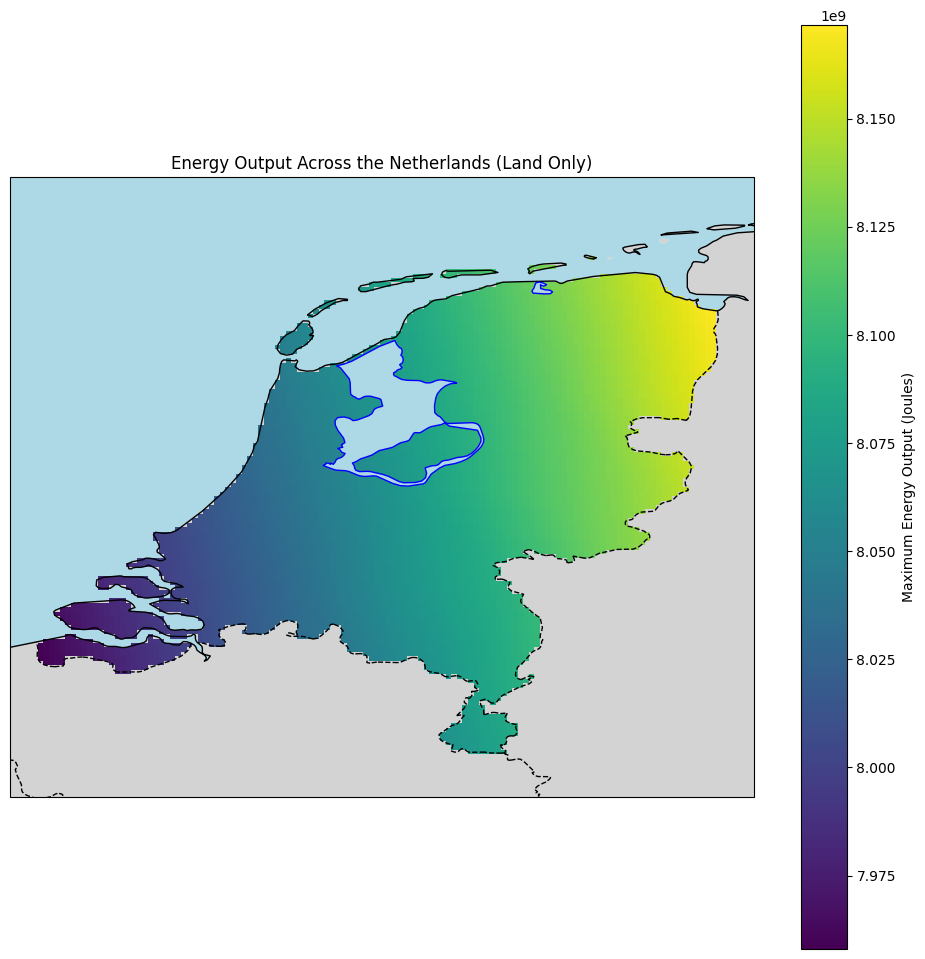

In [28]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Point, Polygon
from scipy.interpolate import griddata

# Load the grid results from the provided CSV
grid_results_df = pd.read_csv('Netherlands_Energy_Grid_Results.csv')

# Extract data for plotting
lon = grid_results_df["Longitude"].values
lat = grid_results_df["Latitude"].values
energy_output = grid_results_df["Maximum Energy Output (Joules)"].values

# Create a grid for longitude and latitude
num_points = 200  # Increase number of interpolation points for better resolution
lon_grid = np.linspace(min(lon), max(lon), num_points)
lat_grid = np.linspace(min(lat), max(lat), num_points)
lon_grid, lat_grid = np.meshgrid(lon_grid, lat_grid)

# Interpolate the energy output onto the grid
grid_values = griddata(
    (lon, lat), energy_output, (lon_grid, lat_grid), method="linear"
)

# Load the Netherlands shapefile
shapefile_path = "ne_10m_admin_0_countries.shp"  # High-resolution shapefile for land
world = gpd.read_file(shapefile_path)

# Filter for the Netherlands and its land boundaries
netherlands = world[world['ADMIN'] == 'Netherlands']
land_polygon = netherlands.geometry.iloc[0]  # Use the Netherlands' land geometry

# Create a mask: Points inside the land area of the Netherlands
mask = np.array([
    Point(lon, lat).within(land_polygon)
    for lon, lat in zip(lon_grid.ravel(), lat_grid.ravel())
]).reshape(lon_grid.shape)

# Apply the land mask to the interpolated grid
grid_values[~mask] = np.nan  # Set values outside land to NaN

# Plot the heatmap over the Netherlands
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={"projection": ccrs.PlateCarree()})
ax.set_extent([3.2, 7.4, 50.5, 54.0], crs=ccrs.PlateCarree())  # Extent for the Netherlands

# Add natural features to the map
ax.add_feature(cfeature.COASTLINE, edgecolor="black", linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black")
ax.add_feature(cfeature.LAND, facecolor="lightgray")
ax.add_feature(cfeature.OCEAN, facecolor="lightblue")
ax.add_feature(cfeature.LAKES, edgecolor="blue", facecolor="lightblue")

# Overlay the interpolated heatmap on land areas
heatmap = ax.pcolormesh(
    lon_grid,
    lat_grid,
    grid_values,
    cmap="viridis",
    shading="nearest",
    transform=ccrs.PlateCarree(),
)

# Add a colorbar
plt.colorbar(heatmap, ax=ax, orientation="vertical", label="Maximum Energy Output (Joules)")

# Add title
ax.set_title("Energy Output Across the Netherlands (Land Only)")
plt.show()


In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point

def main():
    # --- 1. Load shapefile ---
    shapefile_path = "nl_1km.shp"
    netherlands_gdf = gpd.read_file(shapefile_path)

    print("\n=== Original Shapefile Info ===")
    print("CRS:", netherlands_gdf.crs)
    print("Columns:", netherlands_gdf.columns)
    print("Number of features:", len(netherlands_gdf))

    # --- 2. Reproject to EPSG:4326 if needed ---
    if netherlands_gdf.crs is not None and netherlands_gdf.crs.to_string() != "EPSG:4326":
        netherlands_gdf = netherlands_gdf.to_crs(epsg=4326)
        print("\nReprojected shapefile to EPSG:4326.")
    else:
        print("\nShapefile is already in EPSG:4326.")
    
    # Print bounding box for the reprojected shapefile
    bounds = netherlands_gdf.total_bounds  # [minx, miny, maxx, maxy]
    print("Shapefile bounding box [lon_min, lat_min, lon_max, lat_max]:", bounds)

    # --- 3. Load CSV data ---
    csv_path = "Netherlands_Energy_Grid_Results.csv"
    grid_df = pd.read_csv(csv_path)
    
    # Make sure columns exist
    assert "Latitude" in grid_df.columns, "CSV missing 'Latitude' column"
    assert "Longitude" in grid_df.columns, "CSV missing 'Longitude' column"
    
    # Print CSV info
    print("\n=== CSV Info ===")
    print(grid_df.head())
    lat_min, lat_max = grid_df["Latitude"].min(), grid_df["Latitude"].max()
    lon_min, lon_max = grid_df["Longitude"].min(), grid_df["Longitude"].max()
    print(f"CSV lat range: {lat_min} to {lat_max}")
    print(f"CSV lon range: {lon_min} to {lon_max}")

    # --- 4. Quick check: plot shapefile alone in GeoPandas ---
    print("\nShowing shapefile in GeoPandas (no Cartopy). Close the figure to continue...")
    netherlands_gdf.plot(facecolor="none", edgecolor="black")
    plt.title("Netherlands Shapefile Only (GeoPandas)")
    plt.show()

    # --- 5. Quick check: plot CSV points alone in matplotlib ---
    print("\nShowing CSV points alone in lat-lon (no Cartopy). Close the figure to continue...")
    plt.scatter(grid_df["Longitude"], grid_df["Latitude"], s=2, c="red")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("CSV Points Only (matplotlib)")
    plt.show()

    # --- 6. Combine them in Cartopy ---
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature

    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))
    
    # Set the map extent to something that should definitely include NL
    # plus a bit extra around the edges:
    pad = 0.5
    ax.set_extent([lon_min - pad, lon_max + pad, lat_min - pad, lat_max + pad], crs=ccrs.PlateCarree())

    # Add basic cartopy features
    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle='--')
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
    ax.add_feature(cfeature.LAKES, edgecolor='blue', facecolor='lightblue')

    # Plot the CSV points
    ax.scatter(
        grid_df["Longitude"],
        grid_df["Latitude"],
        transform=ccrs.PlateCarree(),
        s=2,
        c="red",
        label="CSV Points"
    )
    
    # Overplot the shapefile boundary
    # Convert the GeoDataFrame to a GeoSeries if needed:
    netherlands_geom = netherlands_gdf.geometry
    # We'll plot it by letting GeoPandas handle the polygons, but must pass in the Cartopy axes:
    netherlands_gdf.boundary.plot(
        ax=ax,
        edgecolor="black",
        linewidth=1,
        transform=ccrs.PlateCarree(),
        label="Shapefile Boundary"
    )

    ax.set_title("Shapefile + CSV Points (Cartopy)")
    ax.legend()
    plt.show()

if __name__ == "__main__":
    main()
